In [1]:
using LinearAlgebra, Statistics, Distributions, Plots, FFTW, SparseArrays

using BenchmarkTools, ProfileView

In [2]:
function initialize(spins::Vector{Vector{Int64}}, coeffs::SparseVector{ComplexF64, Int64})
    L = length(spins[1])
    zeroSpinor = ( [(reverse(digits(i, base=2, pad=L))) for i in 0:2^L-1], spzeros(ComplexF64, 2^L) )
    for i in 1:length(spins)
        for j in 1:length(zeroSpinor[1])
            if spins[i] == zeroSpinor[1][j]
                zeroSpinor[2][j] += coeffs[i]
            end
        end
    end
    return zeroSpinor[2]
end

initialize (generic function with 1 method)

In [3]:
function σx(n::Int, spinArray::SparseVector{ComplexF64, Int64}, newArray::SparseVector{ComplexF64, Int64})
    L = Int(log2(length(spinArray)))
    stride =  2^(L-n)   # 1 if n=4, 2 if n=3, 4 if n=2, 8 if n = 1
    stride2 = 2^(n-1)   # 8 if n=4, 4 if n=3, 2 if n=2, 1 if n = 1

    for i in 1:stride2
        for j in 1:stride
           newArray[2*(i-1)*stride+j], newArray[2*(i-1)*stride+j + stride] = spinArray[2*(i-1)*stride+j + stride], spinArray[2*(i-1)*stride+j]
        end
    end

    return newArray
end

function σy(n::Int, spinArray::SparseVector{ComplexF64, Int64}, newArray::SparseVector{ComplexF64, Int64})
    L = Int(log2(length(spinArray)))
    stride =  2^(L-n)   # 1 if n=4, 2 if n=3, 4 if n=2, 8 if n = 1
    stride2 = 2^(n-1)   # 8 if n=4, 4 if n=3, 2 if n=2, 1 if n = 1

    for i in 1:stride2
        for j in 1:stride
           newArray[2*(i-1)*stride+j], newArray[2*(i-1)*stride+j + stride] = im*spinArray[2*(i-1)*stride+j + stride], -im*spinArray[2*(i-1)*stride+j]
        end
    end

    return newArray
end

function σz(n::Int, spinArray::SparseVector{ComplexF64, Int64}, newArray::SparseVector{ComplexF64, Int64})
    L = Int(log2(length(spinArray)))
    stride =  2^(L-n)   # 1 if n=4, 2 if n=3, 4 if n=2, 8 if n = 1
    stride2 = 2^(n-1)   # 8 if n=4, 4 if n=3, 2 if n=2, 1 if n = 1

    for i in 1:stride2
        for j in 1:stride
           newArray[2*(i-1)*stride+j], newArray[2*(i-1)*stride+j + stride] = -spinArray[2*(i-1)*stride+j], spinArray[2*(i-1)*stride+j + stride]
        end
    end

    return newArray
end

function efficσiσj(i,j, spinor1, spinor2, spinor3, theta) # spinor2 and 3 just need to be the same size
    
    if theta != 0.0
        σx(i,σx(j,spinor1, spinor2),spinor2)
        for i in 1:length(spinor3) 
            spinor3[i] = theta*spinor2[i]
        end
        
        σy(i,σy(j,spinor1, spinor2),spinor2)
        for i in 1:length(spinor3) 
            spinor3[i] += theta*spinor2[i]
        end

        σz(i,σz(j,spinor1, spinor2),spinor2)
        for i in 1:length(spinor3) 
            spinor3[i] += spinor2[i]
        end
    else
        σz(i,σz(j,spinor1, spinor2),spinor2)
        for i in 1:length(spinor3) 
            spinor3[i] = spinor2[i]
        end
    end
    return spinor3
    #return theta*σx!(i,σx!(j, spinor)) + theta*σy!(i,σy!(j, spinor)) + σz!(i,σz!(j, spinor))
end


efficσiσj (generic function with 1 method)

In [4]:
#change getJtensor
function getBasis(L) 
    bas = [spzeros(ComplexF64,2^L) for i in 1:2^L]
    for i in 1:2^L
        bas[i][i] = 1.0 + 0.0im
    end
    return bas
end

function operatorToMatrix!(mat, operator, basis)
    for (i,spinorI) in enumerate(basis)
        mat[:, i] = operator(spinorI)
    end
end
function getJtensor(L,β, theta; betaArray=[])
    betas = betaArray == [] ? [β^i for i in 0:L-2] : betaArray
    length(betas) != L-1 ? error("betaArray is wrong length.") : nothing

    jTensor = zeros(2^L, 2^L, Int(L*(L-1)/2))
    basis = getBasis(L)
    s2 = deepcopy(basis[1])
    s3 = deepcopy(basis[1])
    baseIndex = 0
    @views for k in 1:L-1
        for n in 1:L-k
            if betas[k] != 0.0
                operatorToMatrix!(jTensor[:,:,baseIndex + n], x->betas[k]*efficσiσj(n,n+k,x,s2,s3,theta), basis)
            end
        end
        baseIndex += L-k
    end
    return jTensor
end
function getHtensor(L)
    hTensor = zeros(2^L, 2^L, L)
    basis = getBasis(L)
    s2 = deepcopy(basis[1])
    @views for n in 1:L
            operatorToMatrix!(hTensor[:,:,n], x->σz(n,x,s2), basis)
    end
    return hTensor
end
function levelspacing(vals)
    sort!(vals)
    for i in 1:length(vals)-1
        vals[i] = vals[i+1] - vals[i]
    end
    for i in 1:length(vals)-2
        vals[i] = min(vals[i],vals[i+1])/max(vals[i],vals[i+1])
    end
    return mean(@view vals[1:end-2])
end

levelspacing (generic function with 1 method)

In [7]:
function efficientHam(Hspace, hs, js, jTensor, hTensor)
  
    L = Int(log2(size(Hspace)[1]))
    for i in 1:2^L, j in 1:2^L
        Hspace[i,j] = 0.0 + 0.0im
    end
    for j in 1:Int(L*(L-1)/2), m in 1:2^L, n in 1:2^L
        Hspace[m,n] += (js[j] * jTensor[m,n,j])
    end
    
    for j in 1:L, m in 1:2^L, n in 1:2^L
        Hspace[m,n] += hs[j] * hTensor[m,n,j]
    end
    
    return Hspace
end
function getKet(spinArray)
    L = length(spinArray)
    spinBasis=[reverse(digits(i, base=2, pad=length(spinArray))) for i in 0:2^length(spinArray)-1]
    coeffs = spzeros(2^L)
    for i in eachindex(spinBasis)
        coeffs[i] = spinBasis[i] == spinArray ? 1.0 : 0.0
    end
    return coeffs
end
function getSpins!(ket, spinBasis, coeffs) # Clean this up
    L = Int(log2(length(ket)))

    #abs2ket = abs2.(ket)
    coeffs .= 0.0
    
    for i in eachindex(spinBasis)
        if ket[i] != 0.0
            for j in 1:L
                coeffs[j] += abs2(ket[i])*(spinBasis[i][j] == 0 ? -1.0 : 1.0)
            end
        end
    end
    return coeffs
end


function efficU2(Hspace, hs, js, jTensor, hTensor) 
    #return sparse(exp(-im.*efficientHam(Hspace, hs, js, jTensor, hTensor)))
    return exp(-im.*efficientHam(Hspace, hs, js, jTensor, hTensor))
end

function newU1(L, ε)
    mat = zeros(2^L,2^L)
    basis = getBasis(L)
    answers = deepcopy(basis)    
    for i in 1:2^L
        for k in 1:L
            σx(k,basis[i],answers[k])
        end
        for k in 2:L 
            answers[1] += answers[k] # This is where the allocations happen
        end 
        mat[:,i] .= answers[1]
    end
    #return sparse(round.(exp(-im * mat .* (1-ε) * pi/2 ), digits=15))
    return round.(exp(-im * mat .* (1-ε) * pi/2 ), digits=15)
end

#=function U_levelspacing(L, ε, J0, sigJ, sigH, theta)       
    niters=100
    spac = zeros(niters)
    for i in 1:niters
        spac[i] = levelspacing(mod.(real.(round.(-im.*log.(eigvals(U1(L,ε)*U2(L, J0, sigJ, sigH; thet=theta))),digits=10)),2*pi))
    end
    return mean(spac)
end=#

newU1 (generic function with 1 method)

In [8]:

function autocorrelator(spins, Ureal1, Ureal2, N)
    initKet = getKet(spins)
    L = length(spins)
    negOneSpins = replace(spins, 0 => -1)
    basis = [reverse(digits(i, base=2, pad=L)) for i in 0:2^L-1]

    autoCor = zeros(N+1)
    moreSpins = zeros(L,N+1)
    currentKet = deepcopy(initKet)
    newKet = spzeros(2^L)

    autoCor[1] = 1.0
    moreSpins[:,1] = negOneSpins

    for i in 2:N+1
        newKet = Ureal2*Ureal1*currentKet
        getSpins!(newKet, basis, view(moreSpins,:,i))
        #autoCor[i] = mean(moreSpins[:,i].*negOneSpins)
        autoCor[i] = (moreSpins[:,i].*negOneSpins)[Int(round(L/2))]
        currentKet = newKet
    end
    #println(autoCor)
    return autoCor, moreSpins
end
function gethsandjs(niters, L, J0, σj, σh)
    hs = zeros(niters, L)
    js = zeros(niters, Int(L*(L-1)/2))
    for i in eachindex(hs)
        if σh > 0.0
            hs[i] = rand(Uniform(0.0, σh))
        else
            hs[i] = 0.0
        end
    end

    for i in eachindex(js)
        if σj > 0.0
            js[i] = rand(Uniform(J0-σj, J0+σj))
        else
            js[i] = 0.0
        end
    end
    return hs, js
end
function effAvgAutoCor(niters, nperiods, spins, ε, J0, σj, σh, t)
    
    L = length(spins)
    u1 = newU1(L, ε)
    Hspace = zeros(2^L, 2^L)

    hs, js = gethsandjs(niters, L, J0, σj, σh)

    
    cors = zeros(nperiods+1, niters)
    finalCors=zeros(nperiods+1)
    allSpins = zeros(L, nperiods+1, niters)
    jTensor = getJtensor(L, 0.0, t) #β=0.0
    hTensor = getHtensor(L)

    for i in 1:niters
        cors[:,i],allSpins[:,:, i]  = autocorrelator(spins, u1, efficU2(Hspace,  hs[i,:] ,  js[i,:], jTensor, hTensor), nperiods)
        if i % 10 == 0
            println("Finished ",i,"th iteration")
        end
    end
    finalCors = mean(cors, dims=2)
    allSpins[:,:,1] = mean(allSpins,dims=3)
    return finalCors, allSpins[:,:,1]
end

effAvgAutoCor (generic function with 1 method)

## Spin echo - J0 = ε = 0

Finished 10th iteration
Finished 20th iteration
Finished 30th iteration
Finished 40th iteration
Finished 50th iteration
Finished 60th iteration
Finished 70th iteration
Finished 80th iteration
Finished 90th iteration
Finished 100th iteration


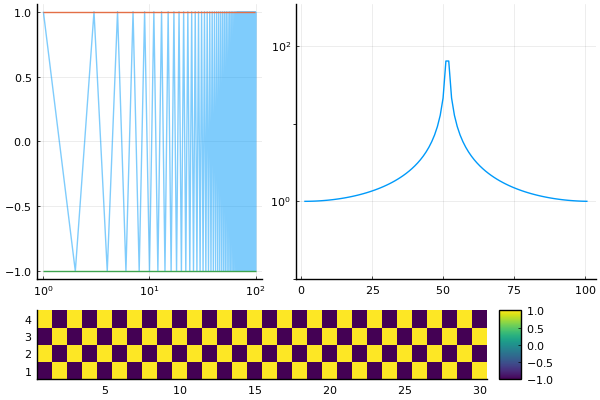

In [9]:
pyplot()
n = 100
realres, spinmap = effAvgAutoCor(100, n, [0,1,0,1], 0.0, 0.0, 0.0, 0.0, 1.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}] 
plot(realres, opacity=0.5,xscale=:log10, legend=false)
plot!(collect(1:2:n),realres[1:2:n])
p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
p3 = heatmap(spinmap[:,1:30], c=:viridis, clims=(-1,1))
plot(p1,p21, p3, layout=l)

## MBL with onsite and Ising-even disorder

Finished 10th iteration
Finished 20th iteration
Finished 30th iteration
Finished 40th iteration
Finished 50th iteration
Finished 60th iteration
Finished 70th iteration
Finished 80th iteration
Finished 90th iteration
Finished 100th iteration


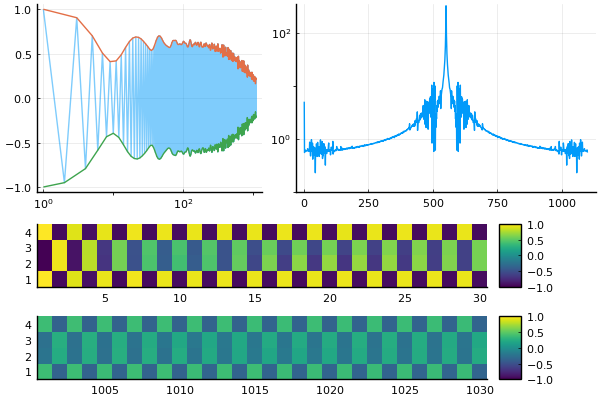

In [ ]:
n = 1100
init=[1,0,0,1] #rand([0,1],6)
jz = 1.0
ε = 0.1
σh = 10.0
realres, spinmap = effAvgAutoCor(100, n, init, ε, jz, 0.2*jz, σh, 0.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}; d{0.2h}] 
plot(realres, opacity=0.5, xscale=:log10, legend=false)
plot!(collect(1:2:n),realres[1:2:n])
p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
p3 = heatmap(spinmap[:,1:30], c=:viridis, clims=(-1,1))
howitsgoing = 1001:1030
p4 = heatmap(collect(howitsgoing), collect(1:length(init)), spinmap[:,howitsgoing], c=:viridis, clims=(-1,1))#print(spinmap[:,1001:1030])
plot(p1,p21, p3, p4, layout=l)

In [14]:
init=[1,0,1,0,1,0]
effAvgAutoCor(100, n, init, ε, jz, 0.2*jz, σh, 0.0)